# Intro to Apache Spark

* [Intro to Spark slides](https://github.com/databricks/tech-talks/blob/master/2020-04-29%20%7C%20Intro%20to%20Apache%20Spark/Intro%20to%20Spark.pdf)
* What is a Spark DataFrame?
  * Read in the [NYT data set](https://github.com/nytimes/covid-19-data) 
* How to perform a distributed count?
* Transformations vs. Actions
* Spark SQL

[Databrick File Systems DBFS](https://docs.databricks.com/data/databricks-file-system.html)

In [0]:
%fs ls databricks-datasets/COVID/covid-19-data/

## How do we represent this data?

![Unified Engine](https://files.training.databricks.com/images/105/unified-engine.png)


####At first there were RDDs...
* **R**esilient: Fault-tolerant
* **D**istributed: Across multiple nodes
* **D**ataset: Collection of partitioned data

RDDs are immutable once created and keep track of their lineage to enable failure recovery.

####... and then there were DataFrames
* Higher-level APIs
* User friendly
* Optimizations and performance improvements

![RDD vs DataFrames](https://files.training.databricks.com/images/105/rdd-vs-dataframes.png)

###Create a DataFrame from the NYT COVID data

In [0]:
covid_df = spark.read.csv("dbfs:/databricks-datasets/COVID/covid-19-data/us-counties.csv")
covid_df.show()

Let's look at the [Spark docs](https://spark.apache.org/docs/latest/index.html) to see what options we have to pass into the csv reader.

In [0]:
covid_df = spark.read.csv("dbfs:/databricks-datasets/COVID/covid-19-data/us-counties.csv", header=True, inferSchema=True)
covid_df.show()

###How many records do we have?
* Instead of counting M&Ms, let's count the number of rows in the DataFrame

###What do we expect our Spark job to look like?
* How many stages?

In [0]:
covid_df.count()

### Let's write some Spark code!

* I want to look at only the information for the county I live in (Boston)
* I want the most recent information at the top

In [0]:
(covid_df
 .sort(covid_df["date"].desc()) 
 .filter(covid_df["county"] == "Providence"))

**...nothing happened. Why?**

## Transformations vs Actions

There are two types of operations in Spark: transformations and actions.

Fundamental to Apache Spark are the notions that
* Transformations are **LAZY**
* Actions are **EAGER**

Why isn't is showing me results? **Sort** and **filter** are `transformations`, which are lazily evaluated in Spark.

Laziness has a number of benefits
* Not forced to load all data in the first step
  * Technically impossible with **REALLY** large datasets.
* Easier to parallelize operations 
  * N different transformations can be processed on a single data element, on a single thread, on a single machine. 
* Most importantly, it allows the framework to automatically apply various optimizations
  * This is also why we use Dataframes!
  
There's a lot Spark's **Catalyst** optimizer can do. Let's focus on only this situation. For more information, read [this blog!](https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html)
  
![Catalyst](https://files.training.databricks.com/images/105/catalyst-diagram.png)

In [0]:
(covid_df
 .sort(covid_df["date"].desc()) 
 .filter(covid_df["county"] == "Providence") 
 .show())  #action!

###We can see the optimizations in action!
* Go to the Spark UI
* Click on the SQL query associated with your Spark job
* See the logical and physical plans!
  * The filter and sort have been swapped

## Spark SQL

In [0]:
covid_df.createOrReplaceTempView("covid")

In [0]:
%sql

SELECT * 
FROM covid

-- keys = date, grouping = county, values = cases

In [0]:
%sql

SELECT * 
FROM covid 
WHERE county = "Providence"

-- keys = date, grouping = county, values = cases, deaths

In [0]:
%sql

SELECT max(cases) AS max_cases, max(deaths) AS max_deaths, county 
FROM covid 
GROUP BY county 
ORDER BY max_cases DESC
LIMIT 10

###Try your own analysis!
* Here's an idea to get you started
* There's a lot more examples [here](https://databricks.com/blog/2020/04/14/covid-19-datasets-now-available-on-databricks.html)

We want to see whether the covid-19 cases/deaths is associated with population.

**This is census data taken from census.gov**
* It has enough information to be able to construct a fips code column that will correspond the the NYT data
* we will download the census data and stored it in /dbfs/tmp folder

In [0]:
import pandas as pd

census=pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv")

## Below command will not work in the community edition

In [0]:
%sh wget https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv && cp co-est2019-alldata.csv dbfs/tmp

### download the census data from [here](https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv) and import it into Databricks

click Data icon on the left and import file co-est2019-alldata.csv into default directory /FileStore/tables

In [0]:
%fs ls /FileStore/tables

In [0]:
census_df = spark.read.csv("/FileStore/tables/co_est2019_alldata.csv", header=True, inferSchema=True)

#display() is a Databricks only function. It displays the data, like show(), but also gives the visualization options we saw in the SQL section above
display(census_df)

Let's tweak the DataFrame above to have a fips column that matches the NYT data. Here's the documentation on [user-defined functions (UDFs)](https://docs.databricks.com/spark/latest/spark-sql/udf-python.html).

### Create a UDF to generate fips based on state and county code in census data

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def make_fips(state_code, county_code):
  if len(str(county_code)) == 1:
    return str(state_code) + "00" + str(county_code)
  elif len(str(county_code)) == 2:
    return str(state_code) + "0" + str(county_code)
  else:
    return str(state_code) + str(county_code)

make_fips_udf = udf(make_fips, StringType())
  
census_df = census_df.withColumn("fips", make_fips_udf(census_df.STATE, census_df.COUNTY))

Now that both the census and the covid data have an identical column, let's join the two DataFrames.

In [0]:
covid_with_census = (covid_df
                     .na.drop(subset=["fips"])
                     .join(census_df.drop("COUNTY", "STATE"), on=['fips'], how='inner'))

What do the cases look like for the most populous counties?

In [0]:
display(covid_with_census.filter("POPESTIMATE2019 > 2000000").select("county", "cases", "date"))

# keys = date, grouping = county, values = cases

Since the NYT dataset has a new row for every day, with cases increasing each day, let's grab only the most recent numbers for each county.
* Below we're using the `col` function to refer to columns. It's equivalent to something like `df["column_name"]`
* To get the most recent row per county,  we'll use a [window function](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=window#pyspark.sql.Window)

In [0]:
from pyspark.sql.functions import row_number, col
from pyspark.sql import Window

w = Window.partitionBy("fips").orderBy(col("date").desc())
current_covid_rates = (covid_with_census
                       .withColumn("row_num", row_number().over(w))
                       .filter(col("row_num") == 1)
                       .drop("row_num"))

What counties are hardest hit when the cases are scaled with their population?

In [0]:
current_covid_rates = (current_covid_rates
                       .withColumn("case_rates_percent", 100*(col("cases")/col("POPESTIMATE2019")))
                       .sort(col("case_rates_percent").desc()))

#Look at the top 10 counties
display(current_covid_rates.select("county", "state", "cases", "POPESTIMATE2019", "case_rates_percent").limit(10))

## In Class Exercises

In [0]:
# import covid data
covid_df = spark.read.csv("dbfs:/databricks-datasets/COVID/covid-19-data/us-counties.csv", header=True, inferSchema=True)


In [0]:
# create a temporary SQL table

covid_df.createOrReplaceTempView('covid_table')

### 1. Display top 10 states based on numbe of cases

In [0]:
%sql

select state, max(cases) as totalCases
from covid_table
group by state
order by totalCases desc
limit 10

state,totalCases
California,1208672
New York,766428
Arizona,519285
Illinois,481101
Florida,423713
Texas,362716
Nevada,229956
Utah,140680
Pennsylvania,121583
Massachusetts,114617


In [0]:
display(spark.sql("select state, max(cases) as totalCases from covid_table group by state order by totalCases desc limit 10"))

state,totalCases
California,1208672
New York,766428
Arizona,519285
Illinois,481101
Florida,423713
Texas,362716
Nevada,229956
Utah,140680
Pennsylvania,121583
Massachusetts,114617


In [0]:
display(covid_df)

date,county,state,fips,cases,deaths
2020-01-21T00:00:00.000+0000,Snohomish,Washington,53061,1,0
2020-01-22T00:00:00.000+0000,Snohomish,Washington,53061,1,0
2020-01-23T00:00:00.000+0000,Snohomish,Washington,53061,1,0
2020-01-24T00:00:00.000+0000,Cook,Illinois,17031,1,0
2020-01-24T00:00:00.000+0000,Snohomish,Washington,53061,1,0
2020-01-25T00:00:00.000+0000,Orange,California,6059,1,0
2020-01-25T00:00:00.000+0000,Cook,Illinois,17031,1,0
2020-01-25T00:00:00.000+0000,Snohomish,Washington,53061,1,0
2020-01-26T00:00:00.000+0000,Maricopa,Arizona,4013,1,0
2020-01-26T00:00:00.000+0000,Los Angeles,California,6037,1,0


### 2. Display number of cases by year and month

In [0]:
%sql

select date_format(date, 'yyyy-MM-dd') as year_month, max(cases), max(deaths)
from covid_table
group by year_month
order by year_month

year_month,max(cases),max(deaths)
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,1,0
2020-01-25,1,0
2020-01-26,1,0
2020-01-27,1,0
2020-01-28,1,0
2020-01-29,1,0
2020-01-30,2,0


### 3. Display number of cases by year and month for top 5 states

In [0]:
%sql

select state, date_format(date, 'yyyy-MM-dd') as year_month, max(cases) as totalCases
from covid_table
where state in (select state from covid_table group by state order by max(cases) desc limit 5)
group by state, year_month
order by state, year_month


state,year_month,totalCases
Arizona,2020-01-26,1
Arizona,2020-01-27,1
Arizona,2020-01-28,1
Arizona,2020-01-29,1
Arizona,2020-01-30,1
Arizona,2020-01-31,1
Arizona,2020-02-01,1
Arizona,2020-02-02,1
Arizona,2020-02-03,1
Arizona,2020-02-04,1


### 4. Display top 5 county for each state based on number of cases

In [0]:
%sql
select * from
(select state, county, totalCases, rank() over (partition by state order by totalCases desc) as rank
from 
(select state, county, max(cases) as totalCases
from covid_table
group by state, county))
where rank<=5

state,county,totalCases,rank
Alabama,Jefferson,72484,1
Alabama,Mobile,36598,2
Alabama,Madison,32818,3
Alabama,Tuscaloosa,24532,4
Alabama,Montgomery,22926,5
Alaska,Anchorage,27066,1
Alaska,Matanuska-Susitna Borough,9091,2
Alaska,Fairbanks North Star Borough,6341,3
Alaska,Kenai Peninsula Borough,4013,4
Alaska,Bethel Census Area,3640,5


### 5. Display top 5 county for each state based on number of cases (limit to top 5 states)

In [0]:
%sql
select * from
(select state, county, totalCases, rank() over (partition by state order by totalCases desc) as rank
from 
(select state, county, max(cases) as totalCases
from covid_table
where state in (select state from covid_table group by state order by max(cases) desc limit 5)
group by state, county))
where rank<=5

state,county,totalCases,rank
Arizona,Maricopa,519285,1
Arizona,Pima,110931,2
Arizona,Pinal,47261,3
Arizona,Yuma,36588,4
Arizona,Mohave,21502,5
California,Los Angeles,1208672,1
California,Riverside,291675,2
California,San Bernardino,288297,3
California,San Diego,264590,4
California,Orange,263279,5


In [0]:
df=spark.sql("select * from (select state, county, totalCases, rank() over (partition by state order by totalCases desc) as rank from (select state, county, max(cases) as totalCases from covid_table where state in (select state from covid_table group by state order by max(cases) desc limit 5) group by state, county)) where rank<=5").toPandas()

df.head()

,state,county,totalCases,rank
0,Arizona,Maricopa,519285,1
1,Arizona,Pima,110931,2
2,Arizona,Pinal,47261,3
3,Arizona,Yuma,36588,4
4,Arizona,Mohave,21502,5


Out[39]: <AxesSubplot:xlabel='totalCases', ylabel='county'>

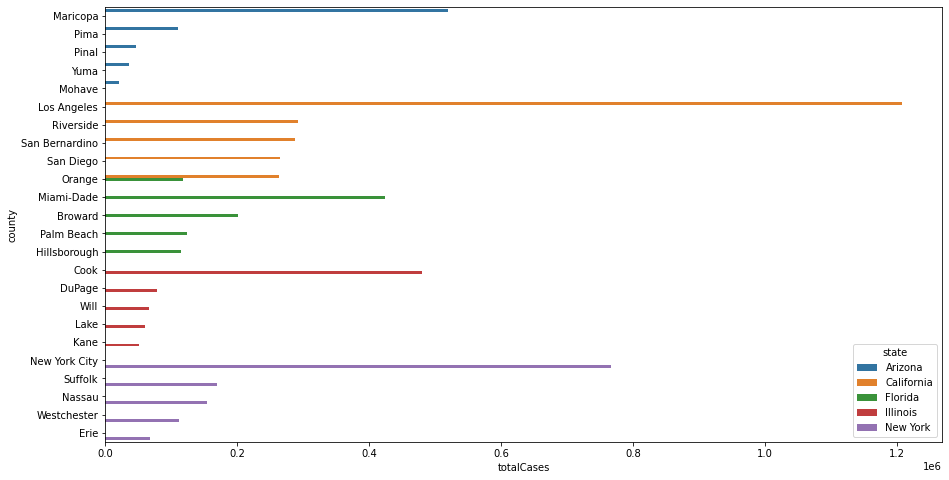

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

rcParams['figure.figsize'] = 15, 8

sns.barplot(y="county", x="totalCases", hue="state",  orient='h', linewidth=3, data=df)